In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import os
from sklearn import model_selection
from keras import applications
from keras.regularizers import l2

# Création des sets d'images et labels

In [3]:
def get_images() :
    
    img_list = []
    start_path = '/content/gdrive/My Drive/assignment_imgs/' # current directory
    
    for path,dirs,files in os.walk(start_path):
        for filename in files:
            img_list.append(os.path.join(path,filename))
    
    return img_list

In [4]:
import pickle

In [5]:
dic_lab = pickle.load(open("/content/gdrive/My Drive/tomato/tomato_label.pkl","rb"))

In [6]:
def create_l_label(paths, dic_lab):
    return [dic_lab[path.split("/")[-1]] for path in paths]

In [7]:
full_images = get_images()
full_labels = create_l_label(get_images(),dic_lab)

# Splitting des sets

In [8]:
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [9]:
undersample = RandomUnderSampler(sampling_strategy=0.5)

In [10]:
X, y = undersample.fit_resample(np.array(full_images).reshape(-1,1), full_labels)
X = [x[0] for x in X]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

In [12]:
train_df = pd.DataFrame({'path': X_train,'label':y_train})
train_df.path = train_df.path.astype(str)
train_df.label = train_df.label.astype(str)

In [13]:
val_df = pd.DataFrame({'path': X_val,'label':y_val})
val_df.path = val_df.path.astype(str)
val_df.label = val_df.label.astype(str)

In [14]:
test_df = pd.DataFrame({'path': X_test,'label':y_test})
val_df.path = val_df.path.astype(str)
test_df.label = test_df.label.astype(str)

In [ ]:
train_df.head()

,path,label
0,/content/gdrive/My Drive/assignment_imgs/20240...,0
1,/content/gdrive/My Drive/assignment_imgs/30918...,0
2,/content/gdrive/My Drive/assignment_imgs/33299...,0
3,/content/gdrive/My Drive/assignment_imgs/21528...,0
4,/content/gdrive/My Drive/assignment_imgs/29963...,1


In [ ]:
train_df['label'].value_counts()

0    640
1    320
Name: label, dtype: int64

<h2> Récupération de l'architecture entrainée et fine-tuning </h2>

In [42]:
xcp = applications.xception.Xception(weights='imagenet', include_top=False)

In [43]:
# Create the model
model = Sequential()
 
# Add the xcp convolutional base model
model.add(xcp)
 
# Add new layers
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate = 0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [44]:
for layer in xcp.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, None, None, 2048)  8192      
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

<h2> Data Augmentation sur les split set </h2>

In [15]:
train_batch_size = 24
val_batch_size = 16
img_width, img_height = 299, 299

In [16]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [17]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col ="path",
    y_col ="label",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=train_batch_size,
    class_mode='binary')

Found 960 validated image filenames belonging to 2 classes.


In [19]:
validation_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col ="path",
    y_col ="label",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=val_batch_size,
    class_mode='binary')

Found 321 validated image filenames belonging to 2 classes.


In [20]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col ="path",
    y_col ="label",
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=1,
    class_mode='binary',
    shuffle=False)

Found 321 validated image filenames belonging to 2 classes.


# Model Training

In [45]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

 
# checkpoints
early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_tomato_model".format(datetime.date.today().strftime("%Y-%m-%d"))
 
bst_model_path = "/content/gdrive/My Drive/tomato/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
save_best_only=True,
save_weights_only=False,
verbose=1)

In [46]:
from keras import optimizers

In [47]:
class_weight = {0: 1,
               1: 3}

In [48]:
model.compile(loss='binary_crossentropy',
               optimizer=optimizers.Adam(lr=0.001), metrics=["acc"])

In [50]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    validation_steps=validation_generator.batch_size // validation_generator.batch_size,
    class_weight = class_weight )

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.0099 - acc: 0.7323
Epoch 00001: val_loss improved from inf to 0.66029, saving model to /content/gdrive/My Drive/tomato/2020-09-28_tomato_model.h5
40/40 [==============================] - 32s 796ms/step - loss: 1.0099 - acc: 0.7323 - val_loss: 0.6603 - val_acc: 0.5625
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.8104 - acc: 0.7531
Epoch 00002: val_loss improved from 0.66029 to 0.35099, saving model to /content/gdrive/My Drive/tomato/2020-09-28_tomato_model.h5
40/40 [==============================] - 32s 809ms/step - loss: 0.8104 - acc: 0.7531 - val_loss: 0.3510 - val_acc: 0.8750
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.6458 - acc: 0.7958
Epoch 00003: val_loss did not improve from 0.35099
40/40 [==============================] - 31s 766ms/step - loss: 0.6458 - acc: 0.7958 - val_loss: 0.3777 - val_acc: 0.8125
Epoch 4/10
40/40 [==============================] - ETA: 0

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
epochs = range(1, len(acc)+1)

# Plot de la training acc / Val acc et Train Loss / Val loss


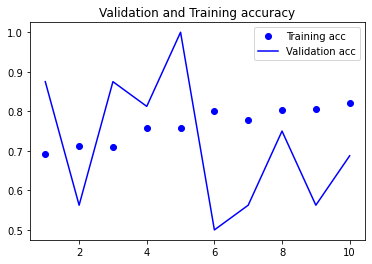

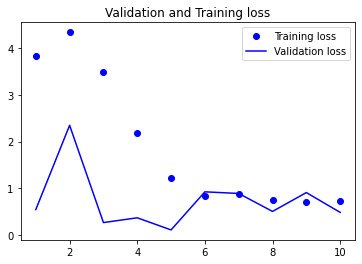

In [ ]:
plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label ='Validation acc')
plt.title("Validation and Training accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label ='Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title("Validation and Training loss")
plt.legend()

plt.show()

# Fine Tuning 

In [25]:
from keras.preprocessing import image
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [51]:
for layer in xcp.layers[15:]:
	layer.trainable = True

for layer in xcp.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fce020445f8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fce76f53080>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fce65d5e7b8>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7fca6a8ce908>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fca71ad42e8>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca6a894940>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7fca6a89e240>: False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7fca6a83acc0>: False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fca6a855358>: False
<tensorflow.python.keras.layers.core.Activation object at 0x7fca6a855550>: False
<tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7fca6a855518>: False
<ten

In [52]:
train_generator.reset()
validation_generator.reset()

In [53]:
model.compile(loss='binary_crossentropy',
               optimizer=optimizers.Adam(lr=0.0001), metrics=["acc"])

In [54]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint],
    validation_steps=validation_generator.batch_size // validation_generator.batch_size,
    class_weight = class_weight )

Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.7435 - acc: 0.8042
Epoch 00001: val_loss improved from 0.31967 to 0.31692, saving model to /content/gdrive/My Drive/tomato/2020-09-28_tomato_model.h5
40/40 [==============================] - 38s 960ms/step - loss: 0.7435 - acc: 0.8042 - val_loss: 0.3169 - val_acc: 0.8125
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.4410 - acc: 0.8750
Epoch 00002: val_loss did not improve from 0.31692
40/40 [==============================] - 37s 927ms/step - loss: 0.4410 - acc: 0.8750 - val_loss: 0.5089 - val_acc: 0.8125
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.2706 - acc: 0.9177
Epoch 00003: val_loss did not improve from 0.31692
40/40 [==============================] - 36s 891ms/step - loss: 0.2706 - acc: 0.9177 - val_loss: 0.3781 - val_acc: 0.7500
Epoch 4/10
40/40 [==============================] - ETA: 0s - loss: 0.2635 - acc: 0.9323
Epoch 00004: val_loss did not improve from 0.

# Calcul de l'erreur sur jeu de test

In [26]:
from keras.models import load_model

model = load_model('/content/gdrive/My Drive/tomato/tune_model.h5')

In [55]:
prediction = model.predict_generator(test_generator, 
                                     steps=len(test_generator), 
                                     max_queue_size=10,
                                     workers=1,
                                     use_multiprocessing=False, 
                                     verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
321/321 [==============================] - 118s 368ms/step


# Optimization of threshold

In [56]:
y_pred = prediction.ravel()

In [57]:
y_true = test_generator.classes

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true, y_pred)

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [58]:
optimal_idx = np.argmax(tpr_keras - fpr_keras)
optimal_threshold = thresholds_keras[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.07752345


In [65]:
print(classification_report(y_true, new_pred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       214
           1       0.64      0.84      0.73       107

    accuracy                           0.79       321
   macro avg       0.77      0.80      0.78       321
weighted avg       0.82      0.79      0.80       321



In [64]:
total = 0
new_pred = []
for i in range(len(y_true)):
    value = 1 if prediction[i][0] > optimal_threshold else 0
    new_pred.append(value)
    if y_true[i]==value:
        total+=1

pourcentage = np.round(total/len(y_true)*100)       
print("Pourcentage de réussite sur un test set inconnu au modèle: ",pourcentage,"%")
print("Erreur sur le jeu de test : ",100 - pourcentage,"%")

Pourcentage de réussite sur un test set inconnu au modèle:  79.0 %
Erreur sur le jeu de test :  21.0 %


# Has_tomatoes() method

In [68]:
def has_tomatoes(img_path,optimal_threshold=0.07752345):
    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img) # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0) # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.
 
    pred = model.predict(img_tensor)

    return True if pred[0][0] > optimal_threshold else False

In [69]:
has_tomatoes("/content/gdrive/My Drive/tomato/test.jpg")

True